## Setup

In [ ]:
!pip install -q albumentations

In [24]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=4589f918029e615f1b04a3d70630adf868a4adc39e2e9e441ca899b99a963e2b
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## ADE20K

In [25]:
import os
import wget
import tarfile

url = "http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip"

output_dir = './ADE20K'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

file_path = os.path.join(output_dir, 'ADEChallengeData2016.zip')
wget.download(url, file_path)

import zipfile
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

## Libraries

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import os
from PIL import Image
import torch.nn.functional as F
import torch.optim as optim

import scipy.ndimage.morphology as morph
import datetime
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

from BEIT import BEiT3
import time

In [2]:
RANDOM_SEED = 42

def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    np.random.seed(RANDOM_SEED)
    torch.backends.cudnn.benchmark = False

set_seed()

## Visualization

In [47]:
label_path = './ADE20K/ADEChallengeData2016/objectInfo150.txt'
labels = []
with open(label_path, 'r') as file:
    for line in file:
        labels.append(line.split("\t")[-1].strip())
labels[0] = 'background'

def color_map(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap

def color_map_viz():
    nclasses = len(labels) - 1
    row_size = 150
    col_size = 300
    cmap = color_map()
    array = np.empty((row_size*(nclasses+1), col_size, cmap.shape[1]), dtype=cmap.dtype)
    for i in range(nclasses):
        array[i*row_size:i*row_size+row_size, :] = cmap[i]
    array[nclasses*row_size:nclasses*row_size+row_size, :] = cmap[-1]

    plt.imshow(array)
    plt.yticks([row_size*i+row_size/2 for i in range(nclasses+1)], labels)
    plt.xticks([])
    plt.show()

# color_map_viz()

ADE_train_00000032


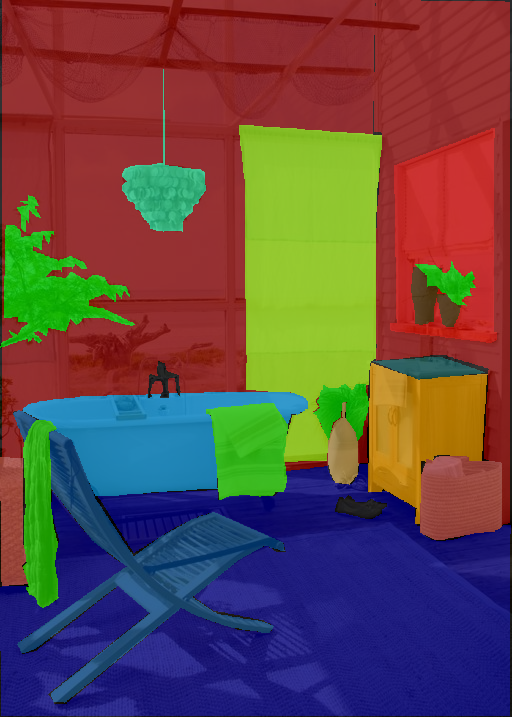

In [48]:
root = './ADE20K/ADEChallengeData2016/'

img_path = root + 'images/training/'
mask_path = root + 'annotations/training/'

img_list = os.listdir(mask_path)
train_set = [os.path.splitext(file)[0] for file in img_list]
train_set.sort()


img_idx = 31

img = Image.open(img_path + train_set[img_idx] + '.jpg')
mask = np.array(Image.open(mask_path + train_set[img_idx] + '.png'))[:, :, np.newaxis]
cmap = color_map()[:, np.newaxis, :]

new_im = np.dot(mask == 0, cmap[0])
for i in range(1, cmap.shape[0]):
    new_im += np.dot(mask == i, cmap[i])
new_im = Image.fromarray(new_im.astype(np.uint8))
blend_image = Image.blend(img, new_im, alpha=0.8)
print(train_set[img_idx])
blend_image

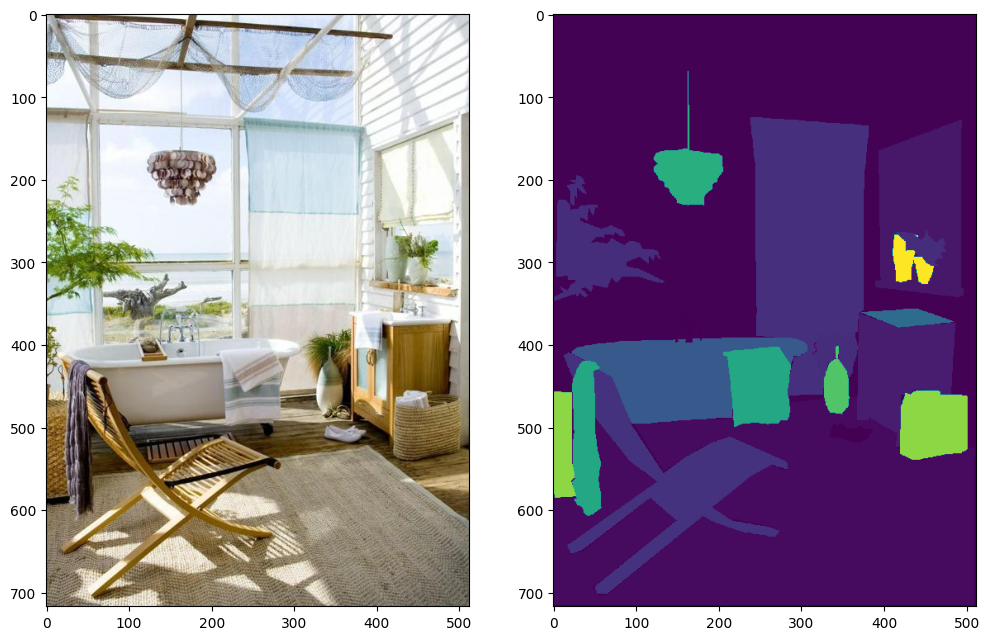

In [49]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

## Dataset

In [44]:
img_transforms = A.Compose([
    A.Resize(height=224, width=224, interpolation=1, always_apply=True),
    ToTensorV2()
])

mask_transforms = A.Compose([
    A.Resize(height=224, width=224, interpolation=0, always_apply=True),
])

In [91]:
class ADE20KDataset(Dataset):
    def __init__(self, root, image_set='train', img_transforms=img_transforms, mask_transforms=mask_transforms):
        self.root = root
        self.image_set = image_set
        self.img_transforms = img_transforms
        self.mask_transforms=mask_transforms

        self.images_dir = os.path.join(root, 'images', image_set)
        self.labels_dir = os.path.join(root, 'annotations', image_set)

        self.images = sorted(os.listdir(self.images_dir))
        self.labels = sorted(os.listdir(self.labels_dir))
        self.num_classes = 150  # ADE20K 클래스 수

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.images[index])
        label_path = os.path.join(self.labels_dir, self.labels[index])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(label_path)

        img = np.array(img).astype(np.float32)
        mask = np.array(mask)

        # 클래스별 마스크 생성
        multi_mask = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)

        for c in range(1, self.num_classes+1):
            multi_mask[:, :, c - 1] = (mask == c)

        if self.img_transforms:
            img = img_transforms(image=img)['image']

        if self.mask_transforms:
            multi_mask= mask_transforms(image=multi_mask)['image']
            multi_mask = torch.from_numpy(multi_mask).permute(2,0,1)

        return img, multi_mask

In [92]:
train_data = ADE20KDataset(root='./ADE20K/ADEChallengeData2016', image_set='training', img_transforms=img_transforms, mask_transforms=mask_transforms)
valid_data = ADE20KDataset(root='./ADE20K/ADEChallengeData2016', image_set='validation', img_transforms=img_transforms, mask_transforms=mask_transforms)

## Dataloader

In [93]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    drop_last=True,
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    drop_last=False
)

## Train

In [96]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)

    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

In [97]:
SAVED_DIR = './'

def save_model(model, file_name='best_model.pt'):
    output_path = os.path.join(SAVED_DIR, file_name)
    torch.save(model, output_path)

In [98]:
def validation(epoch, model, data_loader, criterion, thr=0.5):
    print(f'Start validation #{epoch:2d}')
    model.cuda()
    model.eval()

    dices = []
    with torch.no_grad():
        n_class = 150#len(labels)
        total_loss = 0
        cnt = 0

        for step, (images, masks) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, masks = images.cuda(), masks.cuda()

            outputs = model(images)

            output_h, output_w = outputs.size(-2), outputs.size(-1)
            mask_h, mask_w = masks.size(-2), masks.size(-1)

            # restore original size
            if output_h != mask_h or output_w != mask_w:
                outputs = F.interpolate(outputs, size=(mask_h, mask_w), mode="bilinear")

            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1

            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu()
            masks = masks.detach().cpu()

            dice = dice_coef(outputs, masks)
            dices.append(dice)

    dices = torch.cat(dices, 0)
    dices_per_class = torch.mean(dices, 0)
    dice_str = [
        f"{c:<12}: {d.item():.4f}"
        for c, d in zip(val_labels, dices_per_class)
    ]
    dice_str = "\n".join(dice_str)
    print(dice_str)

    avg_dice = torch.mean(dices_per_class).item()

    return avg_dice

In [106]:
def train(model, data_loader, val_loader, criterion, optimizer):
    print(f'Start training..')
    model.cuda()

    n_class = 150# len(val_labels)
    best_dice = 0.

    for epoch in range(NUM_EPOCHS):
        model.train()

        for step, (images, masks) in enumerate(data_loader):
            # gpu 연산을 위해 device 할당
            images, masks = images.cuda(), masks.cuda()

            # inference
            outputs = model(images)

            # loss 계산
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print(
                    f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(train_loader)}], '
                    f'Loss: {round(loss.item(),4)}'
                )

        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % VAL_EVERY == 0:
            dice = validation(epoch + 1, model, val_loader, criterion)

            if best_dice < dice:
                print(f"Best performance at epoch: {epoch + 1}, {best_dice:.4f} -> {dice:.4f}")
                print(f"Save model in {SAVED_DIR}")
                best_dice = dice
                save_model(model)

In [107]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels=1024, num_classes=150 ):
        super(ASPP, self).__init__()
        # atrous 3x3, rate=6
        self.conv_3x3_r6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=6, dilation=6)
        # atrous 3x3, rate=12
        self.conv_3x3_r12 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=12, dilation=12)
        # atrous 3x3, rate=18
        self.conv_3x3_r18 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=18, dilation=18)
        # atrous 3x3, rate=24
        self.conv_3x3_r24 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=24, dilation=24)
        self.drop_conv_3x3 = nn.Dropout2d(0.5)

        self.conv_1x1 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.drop_conv_1x1 = nn.Dropout2d(0.5)

        self.conv_1x1_out = nn.Conv2d(out_channels, num_classes, kernel_size=1)

    def forward(self, feature_map):
        # 1번 branch
        # shape: (batch_size, out_channels, height/output_stride, width/output_stride)
        # print("feature_map = ",feature_map.shape)
        out_3x3_r6 = self.drop_conv_3x3(F.relu(self.conv_3x3_r6(feature_map)))
        out_img_r6 = self.drop_conv_1x1(F.relu(self.conv_1x1(out_3x3_r6)))
        out_img_r6 = self.conv_1x1_out(out_img_r6)
        # 2번 branch
        # shape: (batch_size, out_channels, height/output_stride, width/output_stride)
        out_3x3_r12 = self.drop_conv_3x3(F.relu(self.conv_3x3_r12(feature_map)))
        out_img_r12 = self.drop_conv_1x1(F.relu(self.conv_1x1(out_3x3_r12)))
        out_img_r12 = self.conv_1x1_out(out_img_r12)
        # 3번 branch
        # shape: (batch_size, out_channels, height/output_stride, width/output_stride)
        out_3x3_r18 = self.drop_conv_3x3(F.relu(self.conv_3x3_r18(feature_map)))
        out_img_r18 = self.drop_conv_1x1(F.relu(self.conv_1x1(out_3x3_r18)))
        out_img_r18 = self.conv_1x1_out(out_img_r18)
        # 4번 branch
        # shape: (batch_size, out_channels, height/output_stride, width/output_stride)
        out_3x3_r24 = self.drop_conv_3x3(F.relu(self.conv_3x3_r24(feature_map)))
        out_img_r24 = self.drop_conv_1x1(F.relu(self.conv_1x1(out_3x3_r24)))
        out_img_r24 = self.conv_1x1_out(out_img_r24)

        out = sum([out_img_r6, out_img_r12, out_img_r18, out_img_r24])

        return out

class DeepLabV2(nn.Module):
    ## VGG 위에 ASPP 쌓기
    def __init__(self, backbone, classifier, upsampling=8):
        super(DeepLabV2, self).__init__()
        self.backbone = backbone
        self.classifier = classifier
        self.upsampling = upsampling

    def forward(self, x):
        x = self.backbone(x)
        _, _, feature_map_h, feature_map_w = x.size()
        x = self.classifier(x)
        out = F.interpolate(x, size=(feature_map_h * self.upsampling, feature_map_w * self.upsampling), mode="bilinear")
        return out

In [108]:
backbone = BEiT3()
aspp_module = ASPP(in_channels=512, out_channels=256, num_classes=150)
model = DeepLabV2(backbone=backbone, classifier=aspp_module)

In [109]:
LR = 1e-4
NUM_EPOCHS = 4
VAL_EVERY = 1

In [110]:
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(params=model.parameters(), lr=LR, weight_decay=1e-6)

In [111]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f'Total number of parameters: {num_params}')

Total number of parameters: 105214358


In [112]:
train(model, train_loader, valid_loader, criterion, optimizer)

Start training..
2024-08-13 05:54:00 | Epoch [1/4], Step [25/5053], Loss: 0.373
2024-08-13 05:55:21 | Epoch [1/4], Step [50/5053], Loss: 0.124
2024-08-13 05:56:44 | Epoch [1/4], Step [75/5053], Loss: 0.0747
2024-08-13 05:58:15 | Epoch [1/4], Step [100/5053], Loss: 0.0587


KeyboardInterrupt: 